<a href="https://colab.research.google.com/github/Jsgithubchannel/deep_learning_practice/blob/main/situation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 47.3 MB 1.3 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.0 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595737 sha256=6534bb2242a6bcbe17696bea7abf39082d73f9cfaf77129e89bd9b33821ab168
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 61 kB 421 kB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 3.3 MB 51.7 MB/s 
     |████████████████████████████████| 895 kB 45.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13


In [3]:
#Kobert 파일 로드 from github
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-bxh5v8cr
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-bxh5v8cr
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=13136 sha256=308c17d8c4a1d61ee64e6112d21c2029c5822171d846b824673d1a923929492b
  Stored in directory: /tmp/pip-ephem-wheel-cache-lazhybj9/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [4]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
#GPU 사용 시
device = torch.device("cuda:0")
#device = torch.device("cpu")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 2. 데이터셋 전처리
import pandas as pd
chat_data = pd.read_excel('/content/drive/MyDrive/capstone_design/reduced_situation_dataset.xlsx')

In [10]:
print(len(chat_data)) # 데이터 개수
chat_data.sample(n=10) # 랜덤 데이터 10개 출력

49660


,situation,sentence1,sentence2,sentence3
11053,대인관계,친구가 나에게 잘못을 했는데 그 친구를 잃기 싫어서 모른 척하고 지내는 상황이 너무...,왜 내가 잘못한 것도 아닌데 눈치를 봐야 하는 걸까 생각하니 너무 슬퍼.,친구에게 그 잘못에 대한 사과를 받는 것이 좋겠어.
9689,"건강, 죽음",기억이 가물가물하고 주위에서 내가 같은 이야기를 반복한다고해서 치매 초기 진단을 받았어.,응 그래서 약을 잘 챙겨 먹으려고. 그런데 치매가 진행되어 기억이 사라지다 내가 치...,기억을 완전히 잃는 것이 속 편하지 않을까?
41618,"진로, 취업, 직장",요즘 취업 하기가 하늘의 별 따기에요.,그래도 꾸준히 노력하면 빛을 볼 수 있을거예요.,무슨일로 연락이 오나요?
28481,재정,재정적으로 힘들어지니까 환멸까지 느껴진다.,투자를 잘못해서 이렇게 됐어.,주식투자를 했는데 처음부터 너무 무리했나봐.
8830,"건강, 죽음",자궁경부암으로 시간이 얼마 남지 않아 딸의 결혼식을 못 보고 가는 게 슬퍼.,사돈에게도 말을 해야 할지 말아야 할지 고민이야.,말을 하는 게 아무래도 좋을 거 같아.
37827,"직장, 업무 스트레스",요즘 기업은 젊은 직원들만 선호해서 너무 힘들어. 일하는데 나이는 상관이 없는데 말이야.,내 열정은 젊은이들 못지않은데 왜 기업들은 그럴까? 오히려 젊은 직원들은 노련미가 없어.,내가 더 열심히 일해서 필요한 사람이 되어야겠어.
44437,학교폭력/따돌림,난 그동안 친구가 학교 폭력을 당하고 있는 걸 알면서도 당황해서 모른 척했어.,친구의 고통을 방관했던 내가 부끄럽고 한심해.,일단 그 친구를 위로해주고 친구와 함께 어른들께 도움을 요청해야겠어.
19779,"대인관계(부부, 자녀)",남편이 꼭 해야 할 말을 안 해주니 답답하고 좌절감이 드네.,부인에게 이야기 안 하면 누구한테 말하겠어. 말을 해주면 좋으련만.,평생을 입 다물고 있는 사람이 말을 해주겠어?
21430,"대인관계(부부, 자녀)",요즘 맘 같아서는 이혼하고 싶어.,다 돈 때문이지. 돈이 없으니까 애들과도 안 좋고 남편은 남의 집 구경하듯 하고 있고.,뾰족한 수가 있나? 결국은 돈이 해결해 줄 문제라서 답이 없는 걸.
6355,"건강, 죽음",안타까운 마음이 들어.,몸에 좋다는 것을 닥치는 대로 먹는 사람을 보니까.,품위있게 사는게 중요한데 너무 오래 살려고만 하는 것 같아서.


In [11]:
situations = ['가족관계','학업 및 진로','학교폭력/따돌림','대인관계(부부, 자녀)','대인관계','연애, 결혼, 출산', '진로, 취업, 직장', '재정, 은퇴, 노후준비', '건강, 죽음', '건강', '직장, 업무 스트레스', '재정'] # 감정 대분류
for i in range(len(situations)):
  chat_data.loc[(chat_data['situation'] == situations[i]), 'situation'] = i

In [12]:
data_list = []
for label, sentence1, sentence2, sentence3 in zip(chat_data['situation'], chat_data['sentence1'], chat_data['sentence2'], chat_data['sentence3']):
    data = []
    sentence = sentence1+' '+sentence2+' '+sentence3
    data.append(sentence)
    data.append(str(label))

    data_list.append(data)

In [13]:
data_list[49000]

['공부가 내 길이 아니라 공부를 안하는 것 뿐이야. 공부가 내 길이 아니라 가수가 내 길이라서 안하는거 뿐이야. 난 노래 연습을 할거야 그거면 돼.',
 '1']

In [14]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [15]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [16]:
# Setting parameters
max_len = 200
batch_size = 16
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [17]:
print(len(dataset_train))
print(len(dataset_test))

39728
9932


In [18]:
#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

#BERT 모델, Vocabulary 불러오기
from kobert.pytorch_kobert import get_kobert_model
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file) 

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-urpwm61y/kobert-tokenizer_e5d5009d46094bce9179aa046d387c8a
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-urpwm61y/kobert-tokenizer_e5d5009d46094bce9179aa046d387c8a
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4648 sha256=fa013c0edeb3728dd4eecbfc16cb4e9b1f41acde32cdd9cee2007ba5048a4273
  Stored in directory: /tmp/pip-ephem-wheel-cache-oyece0ha/wheels/10/b4/d9/cb627bbfaefa266657b0b4e8127f7bf96d27376fa1a23897b4
Successfully built kobert-tokenizer


Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


Downloading:   0%|          | 0.00/535 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

In [19]:
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok,vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok,vocab,  max_len, True, False)

In [20]:
data_train[0]

(array([   2, 4162, 6356, 5468, 7234, 1846, 3111, 5398, 5859, 3135, 7828,
        4627, 5330, 1567, 3194, 5940, 6022, 2752, 5931, 3191, 3574, 6585,
        1852, 5760,  517, 5617, 7096, 3128,  517, 5499, 7350, 5663, 5782,
          54,   54, 2251, 7832, 3191, 1958, 6150, 2307, 5920, 6113, 6113,
        7784, 4966, 1562, 5330, 3105, 5850,  517, 5617, 6368, 3059, 6553,
        5100, 5671, 5702,   54, 3192, 5760, 4799, 7659, 6116,  517, 7375,
        5357, 6553, 1610, 2437, 7088,  775, 2251, 7788, 4435, 3135, 7811,
        4077, 6116, 2086, 6291, 5859, 1189, 4156, 7836, 5377, 6844,   54,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1, 

In [21]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
# 5. KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=12, ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [23]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [24]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/capstone_design/checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [45]:
def train_model(model, batch_size, patience, num_epochs):
  # 6. KoBERT 모델 학습시키기

  train_losses = [] # 모델이 학습되는 동안 trainning loss를 track
  valid_losses = [] # 모델이 학습되는 동안 validation loss를 track
  avg_train_losses = [] # epoch당 average training loss를 track
  avg_valid_losses = [] # epoch당 average validation loss를 track

  # early_stopping object의 초기화
  early_stopping = EarlyStopping(patience = patience, verbose = True)

  for epoch in range(1, num_epochs + 1):
      train_acc = 0.0
      test_acc = 0.0
      ###################
      # train the model #
      ###################
      model.train()
      for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
          optimizer.zero_grad()

          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)

          out = model(token_ids, valid_length, segment_ids)

          loss = loss_fn(out, label)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()
          scheduler.step()  # Update learning rate schedule
          train_acc += calc_accuracy(out, label)
          if batch_id % log_interval == 0:
              print("epoch {} batch id {} loss {} train acc {}".format(epoch, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
      train_losses.append(loss.item()) # train loss 기록



      ######################    
      # validate the model #
      ######################
      model.eval()
      for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)

          out = model(token_ids, valid_length, segment_ids)
          test_acc += calc_accuracy(out, label)
          loss = loss_fn(out, label) # loss 계산
          valid_losses.append(loss.item()) # vaildation loss 기록
      print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))

      # print 학습/검증 statistics
      # epoch당 평균 loss 계산
      train_loss = np.average(train_losses)
      valid_loss = np.average(valid_losses)
      avg_train_losses.append(train_loss)
      avg_valid_losses.append(valid_loss)

      epoch_len = len(str(num_epochs))
      print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                        f'train_loss: {train_loss:.5f} ' +
                        f'valid_loss: {valid_loss:.5f}')
      print(print_msg)

      # 다음 에폭 track하기 위해 리스트 초기화
      train_losses = []
      valid_losses = []

      # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
      # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
      early_stopping(valid_loss, model)

      if early_stopping.early_stop:
        print("Early stopping")
        break

  # best model이 저장되어있는 last checkpoint를 로드한다.
  model.load_state_dict(torch.load('checkpoint.pt'))

  return  model, avg_train_losses, avg_valid_losses

#모델 학습

In [ ]:
# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, num_epochs)   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.42507392168045044 train acc 0.9375
epoch 1 batch id 201 loss 0.0971856638789177 train acc 0.9222636815920398
epoch 1 batch id 401 loss 0.09100864082574844 train acc 0.9211346633416458
epoch 1 batch id 601 loss 0.020310169085860252 train acc 0.9236688851913477
epoch 1 batch id 801 loss 0.5347952842712402 train acc 0.9247815230961298
epoch 1 batch id 1001 loss 0.25097084045410156 train acc 0.926510989010989
epoch 1 batch id 1201 loss 0.0073420400731265545 train acc 0.9275083263946711
epoch 1 batch id 1401 loss 0.01787075214087963 train acc 0.9281763026409707
epoch 1 batch id 1601 loss 0.117488332092762 train acc 0.9282479700187383
epoch 1 batch id 1801 loss 0.2114637941122055 train acc 0.9290324819544697
epoch 1 batch id 2001 loss 0.2754589915275574 train acc 0.9291291854072964
epoch 1 batch id 2201 loss 0.1407293975353241 train acc 0.9282144479781917
epoch 1 batch id 2401 loss 0.22346016764640808 train acc 0.9270356101624323


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 2 test acc 0.6840110037573806
[  1/100] train_loss: 0.01691 valid_loss: 1.53498
Validation loss decreased (inf --> 1.534980).  Saving model ...


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.09339717775583267 train acc 0.9375
epoch 2 batch id 201 loss 0.21132439374923706 train acc 0.9418532338308457
epoch 2 batch id 401 loss 0.7990351915359497 train acc 0.9381234413965087
epoch 2 batch id 601 loss 0.010129056870937347 train acc 0.9385399334442596
epoch 2 batch id 801 loss 0.2743556499481201 train acc 0.9407771535580525
epoch 2 batch id 1001 loss 0.007223951630294323 train acc 0.9416833166833167
epoch 2 batch id 1201 loss 0.057657789438962936 train acc 0.9421315570358035
epoch 2 batch id 1401 loss 0.0025232359766960144 train acc 0.9437901498929336
epoch 2 batch id 1601 loss 0.21862494945526123 train acc 0.9442145534041224
epoch 2 batch id 1801 loss 0.09912201017141342 train acc 0.9445794003331482
epoch 2 batch id 2001 loss 0.0023912095930427313 train acc 0.9450587206396801
epoch 2 batch id 2201 loss 0.011710426770150661 train acc 0.9442298955020445
epoch 2 batch id 2401 loss 0.006038733758032322 train acc 0.943981674302374


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 3 test acc 0.6920625335480408
[  2/100] train_loss: 0.36447 valid_loss: 1.79989
EarlyStopping counter: 1 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.13038988411426544 train acc 0.9375
epoch 3 batch id 201 loss 0.010217104107141495 train acc 0.9508706467661692
epoch 3 batch id 401 loss 0.055621810257434845 train acc 0.9541770573566085
epoch 3 batch id 601 loss 0.002295510610565543 train acc 0.9573627287853578
epoch 3 batch id 801 loss 0.4124453663825989 train acc 0.9572409488139825
epoch 3 batch id 1001 loss 0.024420877918601036 train acc 0.958041958041958
epoch 3 batch id 1201 loss 0.010741818696260452 train acc 0.958992506244796
epoch 3 batch id 1401 loss 0.14761953055858612 train acc 0.9596270521056388
epoch 3 batch id 1601 loss 0.1603059619665146 train acc 0.9596736414740787
epoch 3 batch id 1801 loss 0.0027693775482475758 train acc 0.9606815657967795
epoch 3 batch id 2001 loss 0.00904501136392355 train acc 0.9611131934032984
epoch 3 batch id 2201 loss 0.0031128576956689358 train acc 0.9612392094502499
epoch 3 batch id 2401 loss 0.001996090169996023 train acc 0.961448354852145


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 4 test acc 0.6988727858293076
[  3/100] train_loss: 0.00189 valid_loss: 1.97395
EarlyStopping counter: 2 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0016608029836788774 train acc 1.0
epoch 4 batch id 201 loss 0.002707607112824917 train acc 0.9689054726368159
epoch 4 batch id 401 loss 0.002671160502359271 train acc 0.9716334164588528
epoch 4 batch id 601 loss 0.0016539737116545439 train acc 0.9718178036605657
epoch 4 batch id 801 loss 0.10367553681135178 train acc 0.9727684144818977
epoch 4 batch id 1001 loss 0.0010930824792012572 train acc 0.9735264735264735
epoch 4 batch id 1201 loss 0.0325237400829792 train acc 0.9746565362198168
epoch 4 batch id 1401 loss 0.5123564004898071 train acc 0.9757316202712348
epoch 4 batch id 1601 loss 0.0012509420048445463 train acc 0.9764990630855716
epoch 4 batch id 1801 loss 0.6702409982681274 train acc 0.977165463631316
epoch 4 batch id 2001 loss 0.0020095978397876024 train acc 0.977667416291854
epoch 4 batch id 2201 loss 0.0014341778587549925 train acc 0.9775954111767379
epoch 4 batch id 2401 loss 0.12086621671915054 train acc 0.9777696793002916


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 5 test acc 0.7008185721953838
[  4/100] train_loss: 0.00105 valid_loss: 2.09685
EarlyStopping counter: 3 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.006293163634836674 train acc 1.0
epoch 5 batch id 201 loss 0.001080075278878212 train acc 0.9822761194029851
epoch 5 batch id 401 loss 0.30089858174324036 train acc 0.9851932668329177
epoch 5 batch id 601 loss 0.000733531080186367 train acc 0.9841930116472546
epoch 5 batch id 801 loss 0.09456440806388855 train acc 0.9843945068664169
epoch 5 batch id 1001 loss 0.0006395441014319658 train acc 0.985452047952048
epoch 5 batch id 1201 loss 0.0007327409111894667 train acc 0.9865216486261449
epoch 5 batch id 1401 loss 0.0005102389259263873 train acc 0.9868397573162027
epoch 5 batch id 1601 loss 0.0007447326788678765 train acc 0.987078388507183
epoch 5 batch id 1801 loss 0.21373890340328217 train acc 0.9875416435313714
epoch 5 batch id 2001 loss 0.0004751125816255808 train acc 0.9879122938530734
epoch 5 batch id 2201 loss 0.0006791956257075071 train acc 0.9878748296228986
epoch 5 batch id 2401 loss 0.0005448489682748914 train acc 0.9876874219075386


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 6 test acc 0.7060856146001074
[  5/100] train_loss: 0.00079 valid_loss: 2.16258
EarlyStopping counter: 4 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.0005756096797995269 train acc 1.0
epoch 6 batch id 201 loss 0.0007834968855604529 train acc 0.9906716417910447
epoch 6 batch id 401 loss 0.0005505347508005798 train acc 0.9922069825436409
epoch 6 batch id 601 loss 0.0006315832142718136 train acc 0.9922004991680532
epoch 6 batch id 801 loss 0.002197470050305128 train acc 0.9921192259675405
epoch 6 batch id 1001 loss 0.0012097969884052873 train acc 0.9925074925074925
epoch 6 batch id 1201 loss 0.0013720596907660365 train acc 0.9927664446294754
epoch 6 batch id 1401 loss 0.0004577056970447302 train acc 0.9928176302640971
epoch 6 batch id 1601 loss 0.0005087723257020116 train acc 0.9930512179887571
epoch 6 batch id 1801 loss 0.0005653311382047832 train acc 0.9932676290949473
epoch 6 batch id 2001 loss 0.0007416412699967623 train acc 0.9931596701649176
epoch 6 batch id 2201 loss 0.0005470642354339361 train acc 0.9929577464788732
epoch 6 batch id 2401 loss 0.00045619101729243994 train acc 0.9931018325697626


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 7 test acc 0.7084004294149222
[  6/100] train_loss: 0.00051 valid_loss: 2.20178
EarlyStopping counter: 5 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.0007419759058393538 train acc 1.0
epoch 7 batch id 201 loss 0.004622660577297211 train acc 0.9934701492537313
epoch 7 batch id 401 loss 0.0004198193782940507 train acc 0.9950124688279302
epoch 7 batch id 601 loss 0.000728958344552666 train acc 0.9954242928452579
epoch 7 batch id 801 loss 0.0007740537403151393 train acc 0.9953183520599251
epoch 7 batch id 1001 loss 0.0005284979706630111 train acc 0.9953796203796204
epoch 7 batch id 1201 loss 0.0004974846378900111 train acc 0.9957847626977518
epoch 7 batch id 1401 loss 0.0007201496046036482 train acc 0.9959850107066381
epoch 7 batch id 1601 loss 0.0005605172482319176 train acc 0.9958229231730169
epoch 7 batch id 1801 loss 0.021923867985606194 train acc 0.9959397556912826
epoch 7 batch id 2001 loss 0.0006046544294804335 train acc 0.9959395302348826
epoch 7 batch id 2201 loss 0.0005067667807452381 train acc 0.9957973648341663
epoch 7 batch id 2401 loss 0.0005145093309693038 train acc 0.9957830070803831


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 8 test acc 0.7104133118625873
[  7/100] train_loss: 0.00063 valid_loss: 2.20308
EarlyStopping counter: 6 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.0005024285637773573 train acc 1.0
epoch 8 batch id 201 loss 0.0006724675768055022 train acc 0.9944029850746269
epoch 8 batch id 401 loss 0.0005122514558024704 train acc 0.9951683291770573
epoch 8 batch id 601 loss 0.00039956095861271024 train acc 0.9953202995008319
epoch 8 batch id 801 loss 0.0006617673207074404 train acc 0.995396379525593
epoch 8 batch id 1001 loss 0.0007072955486364663 train acc 0.9951923076923077
epoch 8 batch id 1201 loss 0.0005505005829036236 train acc 0.9954725228975854
epoch 8 batch id 1401 loss 0.00047652656212449074 train acc 0.9954050678087081
epoch 8 batch id 1601 loss 0.00037510276888497174 train acc 0.995627732667083
epoch 8 batch id 1801 loss 0.0004104162799194455 train acc 0.9956621321488062
epoch 8 batch id 2001 loss 0.0013256900710985065 train acc 0.9956896551724138
epoch 8 batch id 2201 loss 0.0005795636097900569 train acc 0.9956553839164016
epoch 8 batch id 2401 loss 0.0003964723146054894 train acc 0.99554872969596


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 9 test acc 0.7117216854535695
[  8/100] train_loss: 0.00506 valid_loss: 2.25541
EarlyStopping counter: 7 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.0006303751142695546 train acc 1.0
epoch 9 batch id 201 loss 0.0006237857160158455 train acc 0.9931592039800995
epoch 9 batch id 401 loss 0.0004494942259043455 train acc 0.9951683291770573
epoch 9 batch id 601 loss 0.0008011703612282872 train acc 0.995216306156406
epoch 9 batch id 801 loss 0.00060296367155388 train acc 0.9951622971285893
epoch 9 batch id 1001 loss 0.00045264256186783314 train acc 0.9951923076923077
epoch 9 batch id 1201 loss 0.00043133433791808784 train acc 0.9953164029975021
epoch 9 batch id 1401 loss 0.0005348793347366154 train acc 0.995583511777302
epoch 9 batch id 1601 loss 0.0005238892044872046 train acc 0.9957058088694566
epoch 9 batch id 1801 loss 0.00031174125615507364 train acc 0.9956621321488062
epoch 9 batch id 2001 loss 0.0004061710205860436 train acc 0.9955647176411794
epoch 9 batch id 2201 loss 0.0013719138223677874 train acc 0.9953430258973194
epoch 9 batch id 2401 loss 0.0005509154871106148 train acc 0.9951062057476051


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 10 test acc 0.7015901771336553
[  9/100] train_loss: 0.00035 valid_loss: 2.44618
EarlyStopping counter: 8 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.0036631247494369745 train acc 1.0
epoch 10 batch id 201 loss 0.0005373700987547636 train acc 0.9912935323383084
epoch 10 batch id 401 loss 0.00030612587579526007 train acc 0.9926745635910225
epoch 10 batch id 601 loss 0.0002795911568682641 train acc 0.9923044925124792
epoch 10 batch id 801 loss 0.0003273813345003873 train acc 0.9919631710362048
epoch 10 batch id 1001 loss 0.0005048913881182671 train acc 0.9922577422577422
epoch 10 batch id 1201 loss 0.00038403019425459206 train acc 0.9924021648626145
epoch 10 batch id 1401 loss 0.0010767122730612755 train acc 0.9924607423269094
epoch 10 batch id 1601 loss 0.08351236581802368 train acc 0.9921923797626483
epoch 10 batch id 1801 loss 0.0003407667682040483 train acc 0.9915324819544697
epoch 10 batch id 2001 loss 0.0016077865147963166 train acc 0.9914105447276362
epoch 10 batch id 2201 loss 0.00028337311232462525 train acc 0.9913959563834621
epoch 10 batch id 2401 loss 0.0004030237905681133 train acc 0.99044668887

  0%|          | 0/621 [00:00<?, ?it/s]

epoch 11 test acc 0.6973295759527643
[ 10/100] train_loss: 0.00187 valid_loss: 2.46942
EarlyStopping counter: 9 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.02202102355659008 train acc 1.0
epoch 11 batch id 201 loss 0.007353784516453743 train acc 0.9850746268656716
epoch 11 batch id 401 loss 0.1324610710144043 train acc 0.9867518703241895
epoch 11 batch id 601 loss 0.00026945583522319794 train acc 0.9857529118136439
epoch 11 batch id 801 loss 0.0004179572861175984 train acc 0.9847066167290887
epoch 11 batch id 1001 loss 0.00043130660196766257 train acc 0.9847027972027972
epoch 11 batch id 1201 loss 0.0006395105156116188 train acc 0.984179850124896
epoch 11 batch id 1401 loss 0.0003743352717719972 train acc 0.9839846538187009
epoch 11 batch id 1601 loss 0.00033840531250461936 train acc 0.9830965021861336
epoch 11 batch id 1801 loss 0.007694178726524115 train acc 0.982717934480844
epoch 11 batch id 2001 loss 0.0009548451052978635 train acc 0.9820089955022488
epoch 11 batch id 2201 loss 0.15560050308704376 train acc 0.9811733303044071
epoch 11 batch id 2401 loss 0.4101904630661011 train acc 0.980216576426489


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 12 test acc 0.688305152979066
[ 11/100] train_loss: 0.00142 valid_loss: 2.30384
EarlyStopping counter: 10 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.0015928313368931413 train acc 1.0
epoch 12 batch id 201 loss 0.003268434898927808 train acc 0.9779228855721394
epoch 12 batch id 401 loss 0.04425043612718582 train acc 0.9761533665835411
epoch 12 batch id 601 loss 0.007550509180873632 train acc 0.9767054908485857
epoch 12 batch id 801 loss 0.08992407470941544 train acc 0.9762016229712859
epoch 12 batch id 1001 loss 0.000624869717285037 train acc 0.9756493506493507
epoch 12 batch id 1201 loss 0.0011991453357040882 train acc 0.9750208159866778
epoch 12 batch id 1401 loss 0.1999102085828781 train acc 0.9743932905067809
epoch 12 batch id 1601 loss 0.41641223430633545 train acc 0.9731027482823236
epoch 12 batch id 1801 loss 0.001631804509088397 train acc 0.9719253192670738
epoch 12 batch id 2001 loss 0.18884749710559845 train acc 0.9711394302848576
epoch 12 batch id 2201 loss 0.07701843976974487 train acc 0.9698432530667879
epoch 12 batch id 2401 loss 0.1322668194770813 train acc 0.969231570179092


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 13 test acc 0.6841451959205582
[ 12/100] train_loss: 0.17474 valid_loss: 2.01838
EarlyStopping counter: 11 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.0023169787600636482 train acc 1.0
epoch 13 batch id 201 loss 0.24908113479614258 train acc 0.9623756218905473
epoch 13 batch id 401 loss 0.02412816509604454 train acc 0.960567331670823
epoch 13 batch id 601 loss 0.004865947179496288 train acc 0.9621464226289518
epoch 13 batch id 801 loss 0.6002896428108215 train acc 0.9615324594257179
epoch 13 batch id 1001 loss 0.06128520891070366 train acc 0.9625374625374625
epoch 13 batch id 1201 loss 0.0037038729060441256 train acc 0.9627393838467944
epoch 13 batch id 1401 loss 0.002493426436558366 train acc 0.9635974304068522
epoch 13 batch id 1601 loss 0.04662199690937996 train acc 0.9634212991880075
epoch 13 batch id 1801 loss 0.00519670732319355 train acc 0.9627290394225431
epoch 13 batch id 2001 loss 0.0011739215115085244 train acc 0.9616441779110445
epoch 13 batch id 2201 loss 0.0014416255289688706 train acc 0.9608416628805089
epoch 13 batch id 2401 loss 0.004038818180561066 train acc 0.9601207830070804


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 14 test acc 0.6804884594739667
[ 13/100] train_loss: 0.28989 valid_loss: 2.14454
EarlyStopping counter: 12 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.0024435489904135466 train acc 1.0
epoch 14 batch id 201 loss 0.5576039552688599 train acc 0.9595771144278606
epoch 14 batch id 401 loss 0.4796624779701233 train acc 0.9551122194513716
epoch 14 batch id 601 loss 0.002140093594789505 train acc 0.9542429284525791
epoch 14 batch id 801 loss 0.8915317058563232 train acc 0.9523252184769039
epoch 14 batch id 1001 loss 0.05127102509140968 train acc 0.9519230769230769
epoch 14 batch id 1201 loss 0.015727918595075607 train acc 0.9530079100749376
epoch 14 batch id 1401 loss 0.2364329695701599 train acc 0.9533369022127052
epoch 14 batch id 1601 loss 0.457666277885437 train acc 0.952998126171143
epoch 14 batch id 1801 loss 0.0022381776943802834 train acc 0.9525263742365353
epoch 14 batch id 2001 loss 0.005775631405413151 train acc 0.9532108945527237
epoch 14 batch id 2201 loss 0.0018450304633006454 train acc 0.9530043162199
epoch 14 batch id 2401 loss 0.0018726971466094255 train acc 0.9525197834235735


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 15 test acc 0.6908883521202362
[ 14/100] train_loss: 0.35079 valid_loss: 2.02332
EarlyStopping counter: 13 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.020977335050702095 train acc 1.0
epoch 15 batch id 201 loss 0.01612657681107521 train acc 0.9521144278606966
epoch 15 batch id 401 loss 0.014826927334070206 train acc 0.9523067331670823
epoch 15 batch id 601 loss 0.014743831008672714 train acc 0.9528910149750416
epoch 15 batch id 801 loss 0.22723373770713806 train acc 0.952247191011236
epoch 15 batch id 1001 loss 0.018960917368531227 train acc 0.9519230769230769
epoch 15 batch id 1201 loss 0.0053294338285923 train acc 0.9531640299750208
epoch 15 batch id 1401 loss 0.0017103994032368064 train acc 0.9538276231263383
epoch 15 batch id 1601 loss 0.0032744219060987234 train acc 0.9537008119925047
epoch 15 batch id 1801 loss 0.005909723229706287 train acc 0.9541227096057746
epoch 15 batch id 2001 loss 0.29609414935112 train acc 0.954272863568216
epoch 15 batch id 2201 loss 0.0021859395783394575 train acc 0.9547080872330759
epoch 15 batch id 2401 loss 0.0029806396923959255 train acc 0.9543679716784673


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 16 test acc 0.6904522275899088
[ 15/100] train_loss: 0.00793 valid_loss: 2.03720
EarlyStopping counter: 14 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0052422513253986835 train acc 1.0
epoch 16 batch id 201 loss 0.1282634735107422 train acc 0.9505597014925373
epoch 16 batch id 401 loss 0.5411947965621948 train acc 0.9572942643391521
epoch 16 batch id 601 loss 0.007997151464223862 train acc 0.9575707154742097
epoch 16 batch id 801 loss 0.40566253662109375 train acc 0.9582553058676654
epoch 16 batch id 1001 loss 0.0014865248231217265 train acc 0.9587912087912088
epoch 16 batch id 1201 loss 0.5892276763916016 train acc 0.9600853455453788
epoch 16 batch id 1401 loss 0.1213904619216919 train acc 0.9604300499643112
epoch 16 batch id 1601 loss 0.01859758235514164 train acc 0.9605324797001874
epoch 16 batch id 1801 loss 0.006036323960870504 train acc 0.9610632981676847
epoch 16 batch id 2001 loss 0.002036688383668661 train acc 0.9615817091454273
epoch 16 batch id 2201 loss 0.004959585145115852 train acc 0.9626874148114494
epoch 16 batch id 2401 loss 0.2567383944988251 train acc 0.9625416493127863


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 17 test acc 0.6871309715512613
[ 16/100] train_loss: 0.00116 valid_loss: 2.26261
EarlyStopping counter: 15 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.008445524610579014 train acc 1.0
epoch 17 batch id 201 loss 0.0011412902968004346 train acc 0.9679726368159204
epoch 17 batch id 401 loss 0.13605128228664398 train acc 0.9671134663341646
epoch 17 batch id 601 loss 0.004505747463554144 train acc 0.9691139767054908
epoch 17 batch id 801 loss 0.001604172051884234 train acc 0.9701154806491885
epoch 17 batch id 1001 loss 0.023051196709275246 train acc 0.9708416583416584
epoch 17 batch id 1201 loss 0.001431663753464818 train acc 0.9718463780183181
epoch 17 batch id 1401 loss 0.00819911528378725 train acc 0.9726534618129907
epoch 17 batch id 1601 loss 0.5122469663619995 train acc 0.9732979387882573
epoch 17 batch id 1801 loss 0.391360342502594 train acc 0.9733134369794558
epoch 17 batch id 2001 loss 0.0008203624747693539 train acc 0.9740129935032483
epoch 17 batch id 2201 loss 0.0005044382414780557 train acc 0.9743298500681509
epoch 17 batch id 2401 loss 0.3405440151691437 train acc 0.974750104123282


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 18 test acc 0.6967928073000537
[ 17/100] train_loss: 0.00044 valid_loss: 2.33453
EarlyStopping counter: 16 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.12537696957588196 train acc 0.9375
epoch 18 batch id 201 loss 0.00044898997293785214 train acc 0.9825870646766169
epoch 18 batch id 401 loss 0.00040989567060023546 train acc 0.98285536159601
epoch 18 batch id 601 loss 0.0003898080321960151 train acc 0.9820091514143094
epoch 18 batch id 801 loss 0.10967474430799484 train acc 0.9818976279650437
epoch 18 batch id 1001 loss 0.000932738184928894 train acc 0.9822677322677322
epoch 18 batch id 1201 loss 0.1505083590745926 train acc 0.982826810990841
epoch 18 batch id 1401 loss 0.002768697449937463 train acc 0.9830924339757316
epoch 18 batch id 1601 loss 0.0004214028886053711 train acc 0.9829793878825734
epoch 18 batch id 1801 loss 0.015344947576522827 train acc 0.9832384786229872
epoch 18 batch id 2001 loss 0.0001938386121764779 train acc 0.9838205897051474
epoch 18 batch id 2201 loss 0.00026987429009750485 train acc 0.9843253066787824
epoch 18 batch id 2401 loss 0.0006442677113227546 train acc 0.9845897542690546


  0%|          | 0/621 [00:00<?, ?it/s]

epoch 19 test acc 0.6998792270531401
[ 18/100] train_loss: 0.02233 valid_loss: 2.45270
EarlyStopping counter: 17 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0009725953568704426 train acc 1.0
epoch 19 batch id 201 loss 0.00018435693345963955 train acc 0.9891169154228856
epoch 19 batch id 401 loss 0.07710202038288116 train acc 0.9898690773067331
epoch 19 batch id 601 loss 0.00016003733617253602 train acc 0.9905366056572379
epoch 19 batch id 801 loss 0.002486780984327197 train acc 0.989856429463171
epoch 19 batch id 1001 loss 0.00029857619665563107 train acc 0.9895729270729271
epoch 19 batch id 1201 loss 0.00018699619977269322 train acc 0.9899562864279767
epoch 19 batch id 1401 loss 0.0001387671218253672 train acc 0.9900071377587437
epoch 19 batch id 1601 loss 0.0005440314998850226 train acc 0.990318550905684
epoch 19 batch id 1801 loss 0.00020842408412136137 train acc 0.9904566907273736
epoch 19 batch id 2001 loss 0.00019234743376728147 train acc 0.9909107946026986
epoch 19 batch id 2201 loss 0.002039675135165453 train acc 0.9911687869150386
epoch 19 batch id 2401 loss 0.0001974260521819815 train acc 0.991305705955

  0%|          | 0/621 [00:00<?, ?it/s]

epoch 20 test acc 0.7033011272141707
[ 19/100] train_loss: 0.01373 valid_loss: 2.58191
EarlyStopping counter: 18 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.00049617700278759 train acc 1.0
epoch 20 batch id 201 loss 0.2916046977043152 train acc 0.9937810945273632
epoch 20 batch id 401 loss 0.00014232109242584556 train acc 0.9953241895261845
epoch 20 batch id 601 loss 0.00013162524555809796 train acc 0.9948003327787022
epoch 20 batch id 801 loss 0.0003294514026492834 train acc 0.9943820224719101
epoch 20 batch id 1001 loss 0.00014150753850117326 train acc 0.994567932067932
epoch 20 batch id 1201 loss 0.00010684234439395368 train acc 0.9949000832639467
epoch 20 batch id 1401 loss 0.00011456599895609543 train acc 0.9951374018558172
epoch 20 batch id 1601 loss 0.00014322226343210787 train acc 0.9953935040599625
epoch 20 batch id 1801 loss 9.068912186194211e-05 train acc 0.9954886174347585
epoch 20 batch id 2001 loss 0.00010193084017373621 train acc 0.9957833583208395
epoch 20 batch id 2201 loss 0.00013544398825615644 train acc 0.9958257610177192
epoch 20 batch id 2401 loss 0.23301027715206146 train acc 0.995887130362

  0%|          | 0/621 [00:00<?, ?it/s]

epoch 21 test acc 0.7067565754159957
[ 20/100] train_loss: 0.00016 valid_loss: 2.61233
EarlyStopping counter: 19 out of 20


  0%|          | 0/2483 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.0001545525446999818 train acc 1.0
epoch 21 batch id 201 loss 9.162179048871621e-05 train acc 0.9975124378109452
epoch 21 batch id 401 loss 0.05399109423160553 train acc 0.9979738154613467
epoch 21 batch id 601 loss 0.0001354589912807569 train acc 0.9976081530782029
epoch 21 batch id 801 loss 0.00020838016644120216 train acc 0.9975811485642946
epoch 21 batch id 1001 loss 0.00013892923016101122 train acc 0.9974400599400599
epoch 21 batch id 1201 loss 0.00010588437726255506 train acc 0.9975541215653622
epoch 21 batch id 1401 loss 0.00010052355355583131 train acc 0.9975910064239829
epoch 21 batch id 1601 loss 0.00011718465248122811 train acc 0.9976186758276078
epoch 21 batch id 1801 loss 9.448926721233875e-05 train acc 0.9975707940033315
epoch 21 batch id 2001 loss 0.028893429785966873 train acc 0.9976261869065467
epoch 21 batch id 2201 loss 0.00011576650285860524 train acc 0.9976431167651068
epoch 21 batch id 2401 loss 0.00013428325473796576 train acc 0.99755310

  0%|          | 0/621 [00:00<?, ?it/s]

epoch 22 test acc 0.7090713902308104
[ 21/100] train_loss: 0.00019 valid_loss: 2.60214
EarlyStopping counter: 20 out of 20
Early stopping


In [44]:
model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

##[참고]loss랑 early stopping 체크포인트 가시화

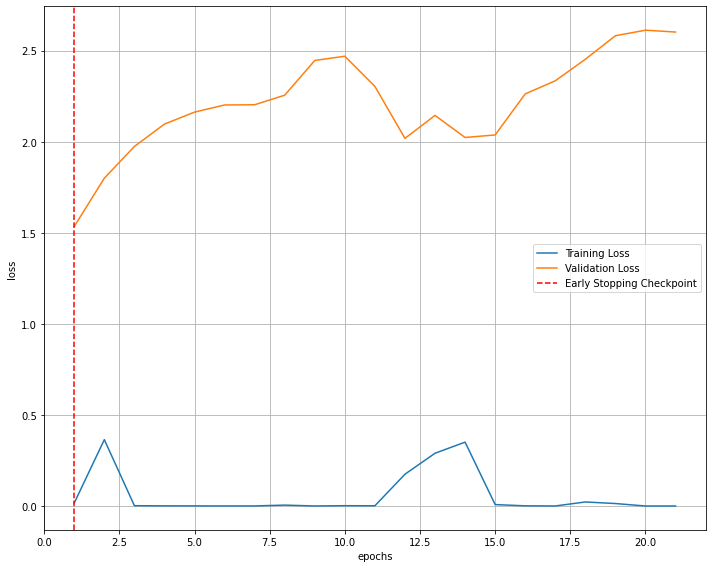

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
# 저장하기
state = {
        'epoch': num_epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': valid_loss,
}
path ="/content/drive/MyDrive/capstone_design/model_epoch.pth"
torch.save(state,path)

In [41]:
# 불러오기
checkpoint = torch.load("/content/drive/MyDrive/capstone_design/model_epoch.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
model.train()

print(epoch)

100


In [26]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("가족관계")
            elif np.argmax(logits) == 1:
                test_eval.append("학업 및 진로")
            elif np.argmax(logits) == 2:
                test_eval.append("학교폭력/따돌림")
            elif np.argmax(logits) == 3:
                test_eval.append("대인관계(부부, 자녀)")
            elif np.argmax(logits) == 4:
                test_eval.append("대인관계")
            elif np.argmax(logits) == 5:
                test_eval.append("연애, 결혼, 출산")
            elif np.argmax(logits) == 6:
                test_eval.append("진로, 취업, 직장")
            elif np.argmax(logits) == 7:
                test_eval.append("재정, 은퇴, 노후준비")
            elif np.argmax(logits) == 8:
                test_eval.append("건강, 죽음")
            elif np.argmax(logits) == 9:
                test_eval.append("건강")
            elif np.argmax(logits) == 10:
                test_eval.append("직장, 업무 스트레스")
            elif np.argmax(logits) == 11:
                test_eval.append("재정")

            print(logits)
        print(">> 입력하신 내용에서 " + test_eval[0] + " 상황입니다.")

In [46]:
#질문 무한반복하기! 0 입력시 종료

end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '0' :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 난 오늘 영어 공부할거야. 근데 너무 재미없어. 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[-1.1013055   6.5590177  -0.31924814  1.4379727  -1.2309328  -2.2149777
 -0.16072324  1.9615135  -1.2365816  -0.02268022 -1.6619114  -1.0906484 ]
>> 입력하신 내용에서 학업 및 진로 상황입니다.


하고싶은 말을 입력해주세요 : 아 배고프다. 오늘 뭐 먹지?
[-1.2237705  -1.1652603  -2.895448   -0.06005225  0.10840134 -1.2835993
  0.02155343  2.7407398  -1.1757743   1.1955037   3.823747   -0.08336579]
>> 입력하신 내용에서 직장, 업무 스트레스 상황입니다.


하고싶은 말을 입력해주세요 : 주식 봤어? 많이 떨어졌던데. 코인도 장난아니게 떨어졌더라
[-2.1005633  -0.64688176 -0.7858581  -1.1319433   0.2397359  -0.9434791
 -1.5916395   2.4309418  -0.699495   -0.43257484 -1.3029535   7.0093737 ]
>> 입력하신 내용에서 재정 상황입니다.


하고싶은 말을 입력해주세요 : 요즘 필라테스를 해서 그런지 건강해진 기분이야. 역시 운동은 중요한가봐
[ 0.57307506 -0.17824969  1.8736899  -1.8462985  -0.6402166  -2.6800218
 -1.798074   -1.644066    4.217953    4.8019466  -1.7600267  -0.04469252]
>> 입력하신 내용에서 건강 상황입니다.


하고싶은 말을 입력해주세요 : 내 친구가 따돌림을 당하는거같아. 선생님께 말씀 드려야겠지?
[-1.7655785   1.147541    7.2119246   2.8695366   0.02345546 -1.0781026
 -2.1890001   0.78220284 -1.7222818  -

In [ ]:
#캐시 삭제
import gc
gc.collect()
torch.cuda.empty_cache()